In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from fastai.vision.all import *

In [2]:
lr = 1e-2
bs = 32
epochs = 50
image_size = 224
device = get_device()

Using the GPU!


In [3]:
p_data = get_data_path()
p_train_valid = p_data/"train_valid_images"
p_train_images = p_train_valid/"train_images"
p_valid_images = p_train_valid/"valid_images"
p_test_images  = p_data/"test_images"
p_dev_images = p_data/"dev_images"

In [4]:
# Load data
label = "Cardiomegaly"
train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                             small=False)
#print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df  = get_binary_df(label, test_df)

complete_df = pd.concat([train_df, valid_df, test_df])
complete_df = complete_df.drop(columns=["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                   "View Position", "OriginalImage[Width", "Height]", 
                   "OriginalImagePixelSpacing[x", "y]", "No Finding"])

In [5]:
def label_func(fname):
    lbl = complete_df[complete_df["Image Index"] == fname.name]["Cardiomegaly"].values[0]
    return "C" if lbl > 0 else "No C"

def splitter_func(fn):
    return fn.parent.stem == "valid_images" 

In [6]:
train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
weights = torch.Tensor([neg_weights, pos_weights]).to(device)
print(neg_weights, pos_weights)

tensor([0.0203]) tensor([0.9797])


In [8]:
item_tfms = Resize(image_size, method="squish", pad_mode="zeros")

batch_tfms = [Brightness(), 
              Contrast(),
#              Warp(),
              RandomErasing(p=.25, max_count=2)
             ]  

In [9]:
#dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                   get_items = get_image_files,
#                   get_y     = label_func,
#                   splitter  = RandomSplitter(),
#                   item_tfms = item_tfms,
#                   batch_tfms = [])#batch_tfms)

#dsets = dblock.datasets(p_dev_images)

In [10]:
#dls = dblock.dataloaders(p_dev_images, bs=bs)

In [11]:
#dls.train.show_batch(max_n=27)

In [12]:
#dls.valid.show_batch(max_n=27)

In [14]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = FuncSplitter(splitter_func),
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms
                   )#

#dsets = dblock.datasets(p_train_valid)

In [15]:
dls = dblock.dataloaders(p_train_valid, bs=bs)

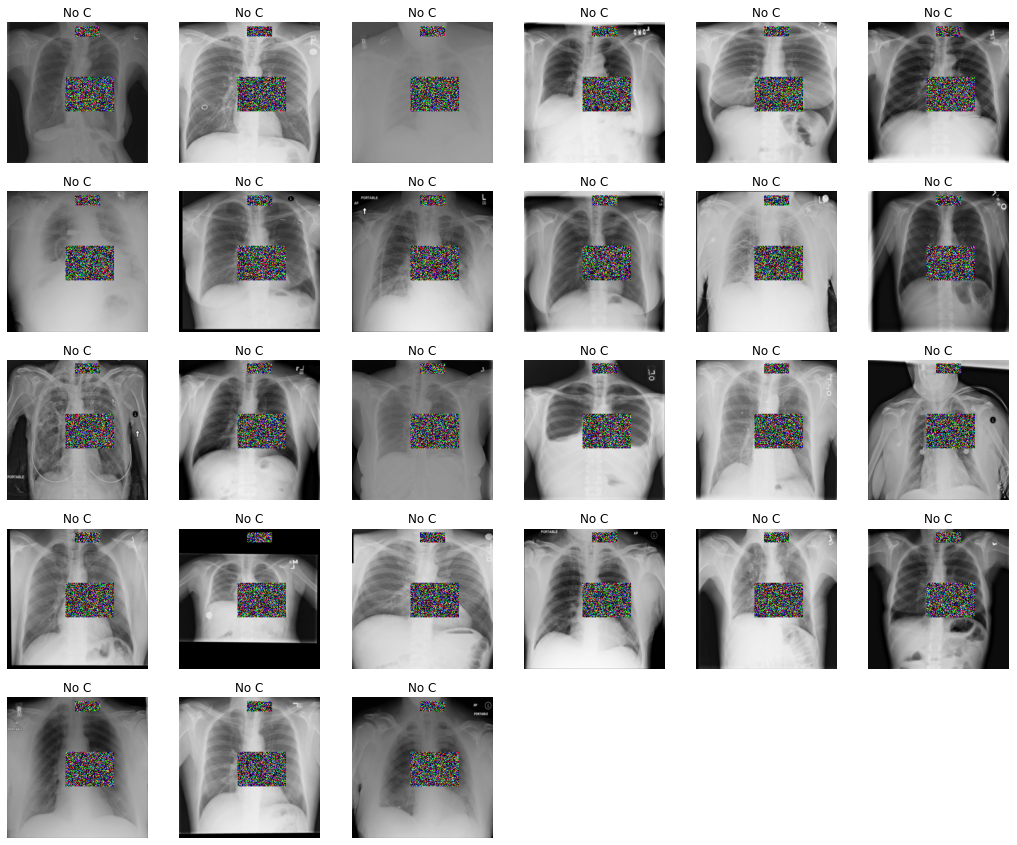

In [16]:
dls.train.show_batch(max_n=27)

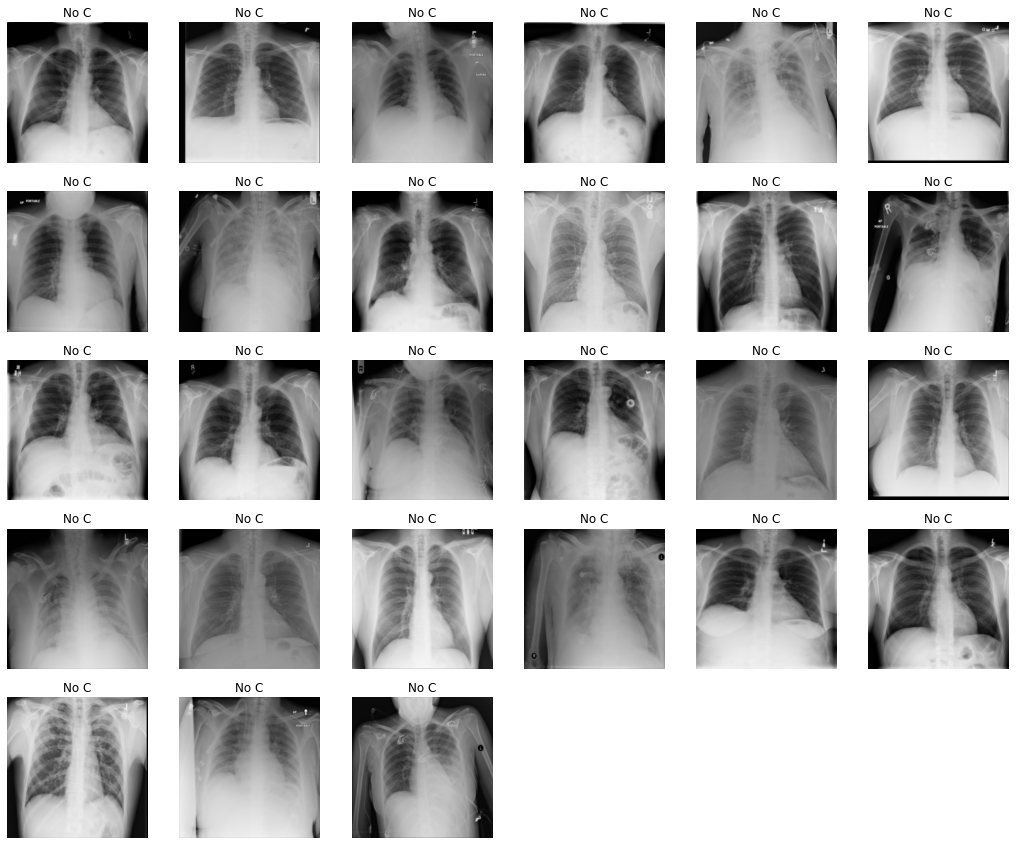

In [17]:
dls.valid.show_batch(max_n=27)

In [ ]:
#dls = dblock.dataloaders(p_train_valid, bs=bs)
#dls.show_batch(max_n=45)

In [32]:
learn = cnn_learner(dls, resnet18, lr=1e-4, loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, Precision(), Recall(), RocAucBinary()])
learn.load(Path().cwd()/"models"/"resnet18_balanced_pretrain_v1")

In [20]:
#learn.load(Path().cwd()/"models"/"resnet18_balanced_pretrain_v1")

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.001737800776027143)

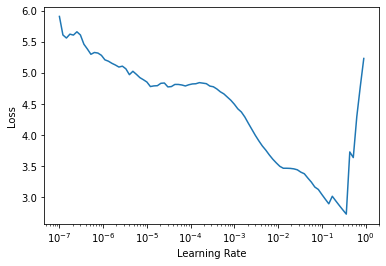

In [21]:
learn.lr_find()

In [33]:
sched = {'lr': SchedCos(1e-3, 1e-7)}

In [34]:
callbacks = [
    ParamScheduler(sched),
    EarlyStoppingCallback(monitor="valid_loss", 
                          patience=5),
    SaveModelCallback(monitor="valid_loss", 
                      fname="resnet18_finetuned_v3"),
    ShowGraphCallback()
]

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,roc_auc_score,time
0,0.088489,0.071983,0.982433,0.983387,0.999000,0.829654,03:00
1,0.088150,0.071492,0.982144,0.984448,0.997589,0.848945,03:01
2,0.061564,0.068711,0.982664,0.982777,0.999882,0.878637,03:01
3,0.060006,0.065985,0.983184,0.983792,0.999353,0.884270,03:01
4,0.063954,0.065343,0.982953,0.983788,0.999118,0.887891,03:02


Better model found at epoch 0 with valid_loss value: 0.07198333740234375.


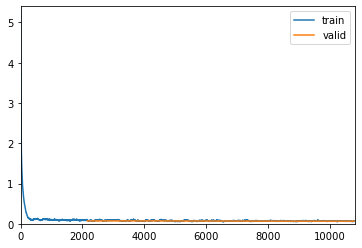

Better model found at epoch 1 with valid_loss value: 0.0714917704463005.
Better model found at epoch 2 with valid_loss value: 0.06871110200881958.
Better model found at epoch 3 with valid_loss value: 0.06598467379808426.
Better model found at epoch 4 with valid_loss value: 0.06534342467784882.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,roc_auc_score,time
0,0.127276,0.093196,0.982722,0.982722,1.000000,0.538339,03:08
1,0.104401,0.091737,0.982722,0.982722,1.000000,0.501152,03:09
2,0.092338,0.082827,0.982722,0.982722,1.000000,0.720206,03:09
3,0.116673,0.083376,0.982722,0.982722,1.000000,0.729020,03:09
4,0.076946,0.080769,0.982722,0.982722,1.000000,0.774768,03:09
5,0.085084,0.078256,0.982722,0.982722,1.000000,0.793965,03:09
6,0.093877,0.076964,0.982722,0.982722,1.000000,0.823686,03:09
7,0.077145,0.070761,0.982722,0.982722,1.000000,0.875320,03:09
8,0.091989,0.068274,0.982722,0.982722,1.000000,0.889599,03:09
9,0.088680,0.067164,0.982780,0.982779,1.000000,0.883102,03:09


Better model found at epoch 0 with valid_loss value: 0.09319564700126648.


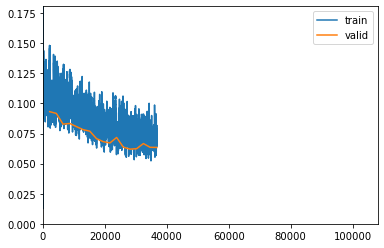

Better model found at epoch 1 with valid_loss value: 0.09173735976219177.
Better model found at epoch 2 with valid_loss value: 0.0828271135687828.
Better model found at epoch 4 with valid_loss value: 0.08076862245798111.
Better model found at epoch 5 with valid_loss value: 0.07825633138418198.
Better model found at epoch 6 with valid_loss value: 0.07696424424648285.
Better model found at epoch 7 with valid_loss value: 0.07076116651296616.
Better model found at epoch 8 with valid_loss value: 0.06827368587255478.
Better model found at epoch 9 with valid_loss value: 0.0671638622879982.
Better model found at epoch 11 with valid_loss value: 0.06369975954294205.
Better model found at epoch 12 with valid_loss value: 0.06202130392193794.
No improvement since epoch 12: early stopping


In [35]:
learn.fine_tune(epochs, 
                freeze_epochs=5, 
                base_lr=1e-3, 
                cbs=callbacks)

In [ ]:
learn.save("resnet18_finetuned_v1", with_opt=True)

In [57]:
?learn.fine_tune

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [ ]:
#interp.plot_top_losses(9)

In [ ]:
#learn.summary()
#learn.lr_find()

In [ ]:
learn.fine_tune(epochs, freeze_epochs=5, base_lr=3e-3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9)

In [ ]:
learn.save("resnet18_v2", with_opt=True)

In [ ]:
test_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        get_y     = label_func,
                        item_tfms = item_tfms[0])

In [ ]:
test_dls = test_dblock.dataloaders(p_test_images, bs=bs)
test_dls.show_batch(max_n=27)

In [ ]:
test_learn = cnn_learner(test_dls, resnet18, lr=1e-4, loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, Precision(), Recall(), RocAucBinary()])

In [ ]:
test_learn.model = learn.model

In [ ]:
interp = ClassificationInterpretation.from_learner(test_learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9)

In [ ]:
interp

In [ ]:
learn.summary()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs, 
                base_lr=0.002, 
                freeze_epochs=0, 
                lr_mult=100, 
                pct_start=0.3, 
                div=5.0, 
                div_final=100000.0, 
                wd=None, moms=None, cbs=None, reset_opt=False)


In [ ]:
#learn.lr_find()

In [ ]:
learn.save("untrained_resnet18", with_opt=True)

In [ ]:
learn.fit_one_cycle(epochs, lr_max=lr)

In [ ]:
learn.fine_tune(3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

In [ ]:
interp.plot_top_losses(9)